In [24]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)

from catboost import CatBoostClassifier, Pool
import optuna

random_state = 42
np.random.seed(random_state)

target_col = "Exited"
id_col = "id"  

In [25]:
def load_data():
    local_dir = Path("data")
    local_train = local_dir / "train.csv"
    local_test  = local_dir / "test.csv"
    local_sub   = local_dir / "sample_submission.csv"

    if local_train.exists() and local_test.exists() and local_sub.exists():
        train_df = pd.read_csv(local_train)
        test_df  = pd.read_csv(local_test)
        sample_sub = pd.read_csv(local_sub)
        source = f"local: {local_dir.resolve()}"
        return train_df, test_df, sample_sub, source

    kaggle_dir = Path("/kaggle/input")
    if kaggle_dir.exists():
        train_files = list(kaggle_dir.rglob("train.csv"))
        test_files  = list(kaggle_dir.rglob("test.csv"))
        sub_files   = list(kaggle_dir.rglob("sample_submission.csv"))

        if train_files and test_files and sub_files:
            train_df = pd.read_csv(train_files[0])
            test_df  = pd.read_csv(test_files[0])
            sample_sub = pd.read_csv(sub_files[0])
            source = f"kaggle: {train_files[0].parent}"
            return train_df, test_df, sample_sub, source

    return None, None, None, "not found"

train_df, test_df, sample_sub, data_source = load_data()
print("Data source:", data_source)

if train_df is not None:
    print("train:", train_df.shape, "| test:", test_df.shape, "| sample_sub:", sample_sub.shape)
    train_df.head()
else:
    print("Files not found: expected ./data/train.csv, ./data/test.csv, ./data/sample_submission.csv (or Kaggle input).")


Data source: kaggle: /kaggle/input/bank-churn-competition-by-msu-x-mts-base-ml-course
train: (15000, 14) | test: (10000, 13) | sample_sub: (10000, 2)


In [26]:
def prepare_dataset(train_df: pd.DataFrame, test_df: pd.DataFrame, target: str):
    train_df = train_df.copy().set_index(id_col)
    test_df = test_df.copy().set_index(id_col)

    cat_cols = ["Geography", "Gender", "NumOfProducts"]
    for c in cat_cols:
        train_df[c] = train_df[c].astype(str)
        test_df[c] = test_df[c].astype(str)

    drop_cols = ["RowNumber", "CustomerId", "Surname"]
    feat_cols = [c for c in train_df.columns if c not in drop_cols + [target]]

    X = train_df[feat_cols].copy()
    y = train_df[target].copy()
    X_test = test_df[feat_cols].copy()

    cat_features_idx = [feat_cols.index(c) for c in cat_cols]

    return train_df, test_df, X, y, X_test, feat_cols, cat_cols, cat_features_idx

## 1. **EDA**

**Предобработка данных**

In [27]:
train_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15653521.0,Nkemakonam,667.0,Germany,Male,33.0,3.0,131769.04,1.0,1.0,1.0,162719.69,0.0
1,1,15699005.0,Chiekwugo,614.0,France,Female,31.0,2.0,110615.47,1.0,1.0,1.0,181879.56,0.0
2,2,15656912.0,Chiang,683.0,Germany,Female,24.0,6.0,115074.02,2.0,1.0,0.0,109688.82,0.0
3,3,15700772.0,Ch'ang,678.0,France,Female,38.0,9.0,0.00,1.0,1.0,0.0,122823.84,1.0
4,4,15583850.0,Chiang,588.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,1.0,136910.18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15793331.0,Kao,537.0,Spain,Female,43.0,8.0,0.00,2.0,1.0,1.0,57762.00,0.0
14996,14996,15651336.0,Kambinachi,669.0,Spain,Female,34.0,4.0,0.00,2.0,0.0,0.0,138775.86,0.0
14997,14997,15764072.0,Chiu,537.0,France,Male,39.0,7.0,0.00,2.0,0.0,0.0,141210.50,0.0
14998,14998,15792868.0,Ts'ai,651.0,France,Male,31.0,9.0,0.00,2.0,1.0,1.0,177655.68,0.0


In [28]:
print(f'train shape {train_df.shape}')
print(f'test shape {test_df.shape}')

train shape (15000, 14)
test shape (10000, 13)


In [29]:
print('train dataset info')
train_df.info()
print()
print('test dataset info')
test_df.info()

train dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB

test dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000

**Null значений нет**

**Проверка на дубли**

In [30]:
train_duplicates = train_df.duplicated().sum()

test_duplicates = test_df.duplicated().sum()

print(f'Количество повторяющихся строк в train {train_duplicates}')
print(f'Количество повторяющихся строк в test {test_duplicates}')

Количество повторяющихся строк в train 0
Количество повторяющихся строк в test 0


****

**Наблюдение 1**

* В датасете 15000 строк и 13 столбцов.
* Данные не содержат дубликатов и пропущенных значений.
* Таргетная переменная - *Exited*.

**Descriptive analysis**

In [31]:
train_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.570226e+07,658.607333,37.721667,5.030800,43100.479284,1.581200,0.789467,0.495400,117824.489347,0.207867
std,4330.271354,1.146899e+06,72.428993,8.167030,2.800876,59903.132500,0.527976,0.407701,0.499996,45487.690876,0.405794
min,0.000000,1.556571e+07,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,1.563652e+07,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83419.490000,0.000000
50%,7499.500000,1.569018e+07,663.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123570.900000,0.000000
75%,11249.250000,1.575758e+07,708.000000,42.000000,7.000000,110125.830000,2.000000,1.000000,1.000000,157097.090000,0.000000
max,14999.000000,1.558890e+08,850.000000,74.000000,10.000000,205962.000000,4.000000,1.000000,1.000000,199953.330000,1.000000


**Наблюдение 2**
1. **Кредитный скор и возраст:**
    * Средний кредит скор примерно равен 658.61.
    * Средний возраст клиентов равен 38.13 лет.
    * Минимальное значение кредитного скора = 431, максимальное = 850.
2. **Финансовый статус:**
    * Средний баланс клиентов около 43100, максимальное значение = 205962.
    * Количество продуктов клиентов принимает значение от 1 до 4.
3. **Банковские услуги:**
    * Большая часть клиентов имеет кредитную карту (78.9%) (HasCrCard).
    * Активных клиентов банка 49.5% (IsActiveMember).
4. **Предполагаемая заработная плата (EstimatedSalary):**
    *  Предполагаемая заработная плата в среднем = 117824.489.
    *  Зарплаты сильно различаются с минимумом = 11.58 и максимумом 199953.33.
5. **Отток клиентов (Customer Churn):**
    * Около 20.7% покинуло банк (Exited = 1).
    * Большинство (около 79.3%) не покинуло банк (Exited = 0).
6. **Выводы:**
    * Датасет отражает разнообразие характеристик и поведения клиентов.
    * Понимание факторов, влияющих на отток клиентов - таких как возраст, количество лет обслуживания и использование продуктов, может быть важным для стратегий удержания клиентов.
    * Нужен дальнейший аналих и построение моделей для выявления закономерностей и прогнозирования оттока.

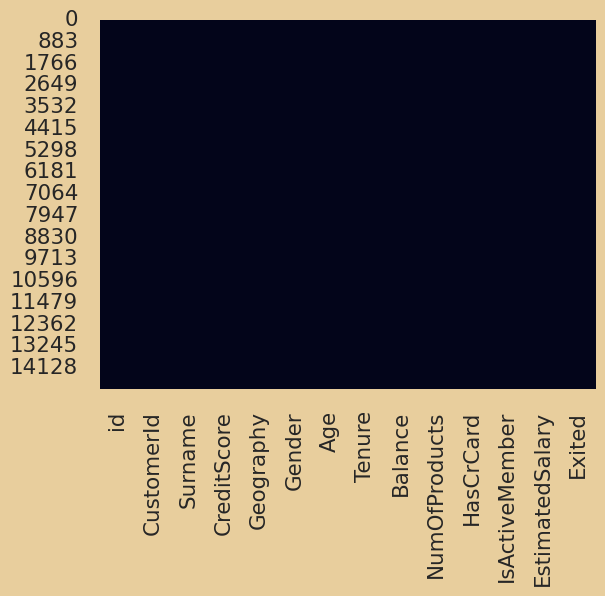

In [32]:
# Визуальное подтверждение, что нулевых значений нет
sns.heatmap(train_df.isnull(), cbar=False)
plt.show()

**Визуализация данных**

In [33]:
#sns.set_style("white")
sns.set(rc={"axes.facecolor":"#E8CE9D","figure.facecolor":"#E8CE9D","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

palette = ["#432C0A","#f7941d","#6c9a76","#f25a29","#ff1947"]
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#ff1947"]


**Gender In The Dataset**

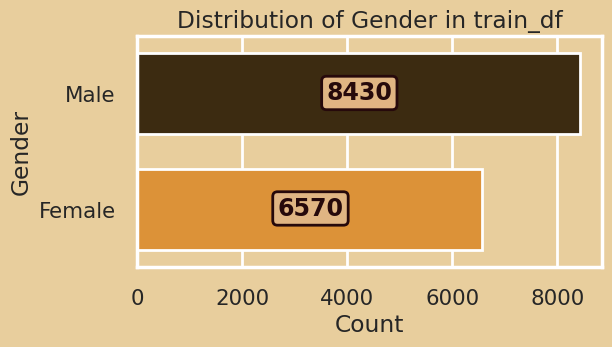

In [34]:
fig = plt.figure(figsize=(6,3))

p = sns.countplot(y="Gender", data=train_df, palette=palette[0:2], linewidth=2, width=0.7)

for container in p.containers:
    plt.bar_label(container, label_type='center', color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                 bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Gender in train_df")
plt.xlabel("Count")
plt.ylabel("Gender")

plt.show()

**Geography In The Dataset**

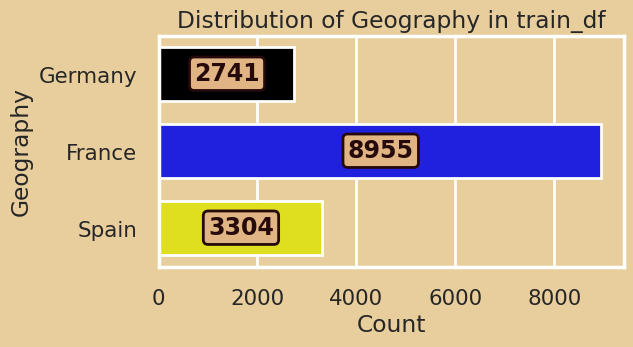

In [35]:
fig = plt.figure(figsize=(6,3))

p = sns.countplot(y="Geography", data=train_df, palette=["black", "blue", "yellow"], linewidth=2, width=0.7)

for container in p.containers:
    plt.bar_label(container, label_type='center', color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                 bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Geography in train_df")
plt.xlabel("Count")
plt.ylabel("Geography")

plt.show()

**Tenure In The Dataset**

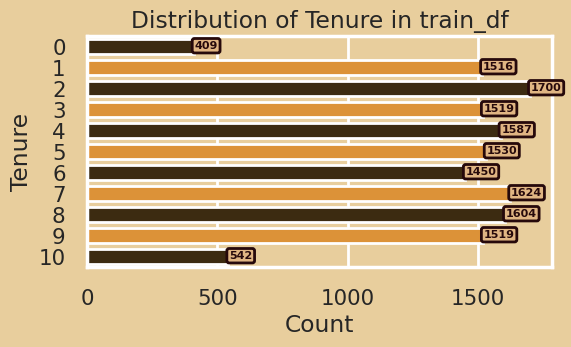

In [36]:
fig = plt.figure(figsize=(6,3))

p = sns.countplot(y=train_df["Tenure"].astype(int), palette=palette[0:2], linewidth=2, width=0.7)

for container in p.containers:
    plt.bar_label(container, label_type='edge', color='#26090b', fontsize=8, weight='bold', padding=6, position=(0.5, 0.5),
                 bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Tenure in train_df")
plt.xlabel("Count")
plt.ylabel("Tenure")

plt.show()

**Number of Products In The Dataset**

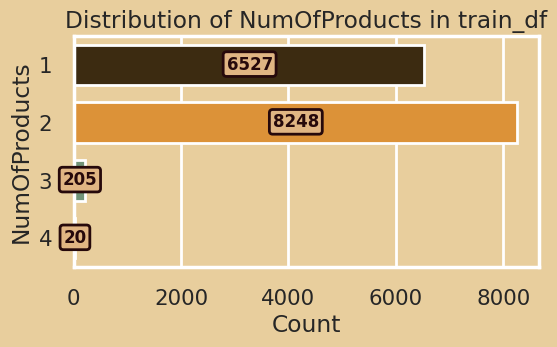

In [37]:
fig = plt.figure(figsize=(6,3))

p = sns.countplot(
    y=train_df["NumOfProducts"].astype(float).astype(int),
    palette=palette, linewidth=2, width=0.7
)

for container in p.containers:
    plt.bar_label(container, label_type='center', color='#26090b', fontsize=12, weight='bold', padding=6, position=(0.5, 0.5),
                 bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of NumOfProducts in train_df")
plt.xlabel("Count")
plt.ylabel("NumOfProducts")
plt.show()


**Has Credit Card In The Dataset**

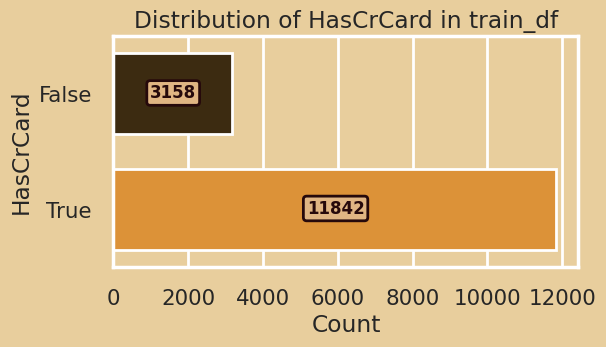

In [38]:
fig = plt.figure(figsize=(6,3))

p = sns.countplot(y=train_df["HasCrCard"].astype(bool), palette=palette[0:2], linewidth=2, width=0.7)

for container in p.containers:
    plt.bar_label(container, label_type='center', color='#26090b', fontsize=12, weight='bold', padding=6, position=(0.5, 0.5),
                 bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of HasCrCard in train_df")
plt.xlabel("Count")
plt.ylabel("HasCrCard")

plt.show()

**Active Customers In The Dataset**

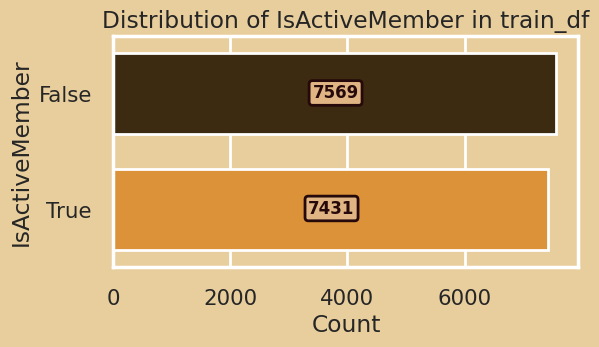

In [39]:
fig = plt.figure(figsize=(6,3))

p = sns.countplot(y=train_df["IsActiveMember"].astype(bool), palette=palette[0:2], linewidth=2, width=0.7)

for container in p.containers:
    plt.bar_label(container, label_type='center', color='#26090b', fontsize=12, weight='bold', padding=6, position=(0.5, 0.5),
                 bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of IsActiveMember in train_df")
plt.xlabel("Count")
plt.ylabel("IsActiveMember")

plt.show()

**Exited In The Dataset**

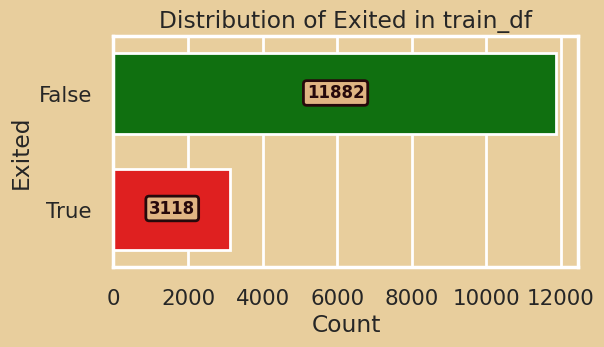

In [40]:
fig = plt.figure(figsize=(6,3))

p = sns.countplot(y=train_df["Exited"].astype(bool), palette=['green', 'red'], linewidth=2, width=0.7)

for container in p.containers:
    plt.bar_label(container, label_type='center', color='#26090b', fontsize=12, weight='bold', padding=6, position=(0.5, 0.5),
                 bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#e0b583", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution of Exited in train_df")
plt.xlabel("Count")
plt.ylabel("Exited")

plt.show()

**Credit Score In The Dataset**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


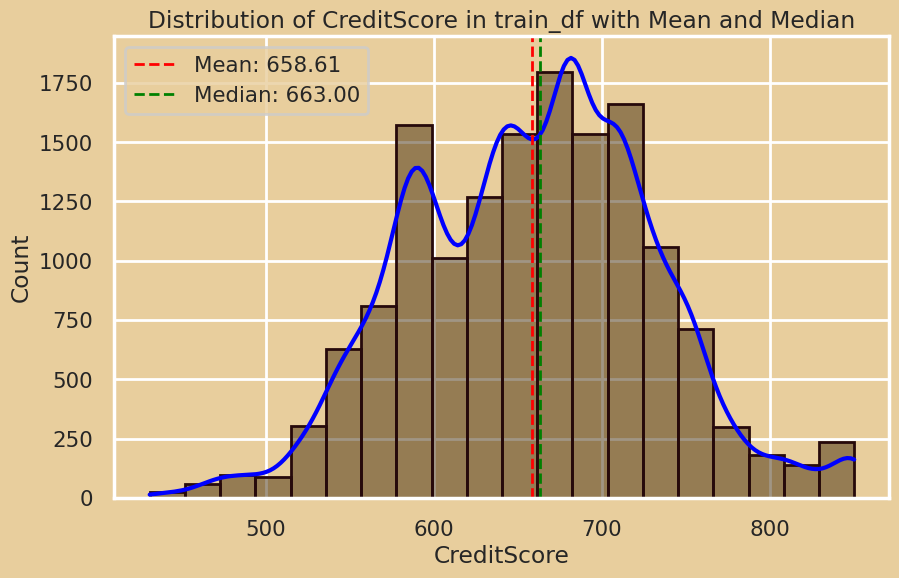

In [41]:
fig = plt.figure(figsize=(10,6))

histplot = sns.histplot(data=train_df, x="CreditScore",
                        bins=20, color='#432C0A', edgecolor='#26090b', kde=True)

histplot.get_lines()[0].set_color('blue')

mean_value = train_df["CreditScore"].mean()
median_value = train_df["CreditScore"].median()

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title("Distribution of CreditScore in train_df with Mean and Median")
plt.xlabel("CreditScore")
plt.ylabel("Count")

plt.legend()

plt.show()

**Age In The Dataset**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


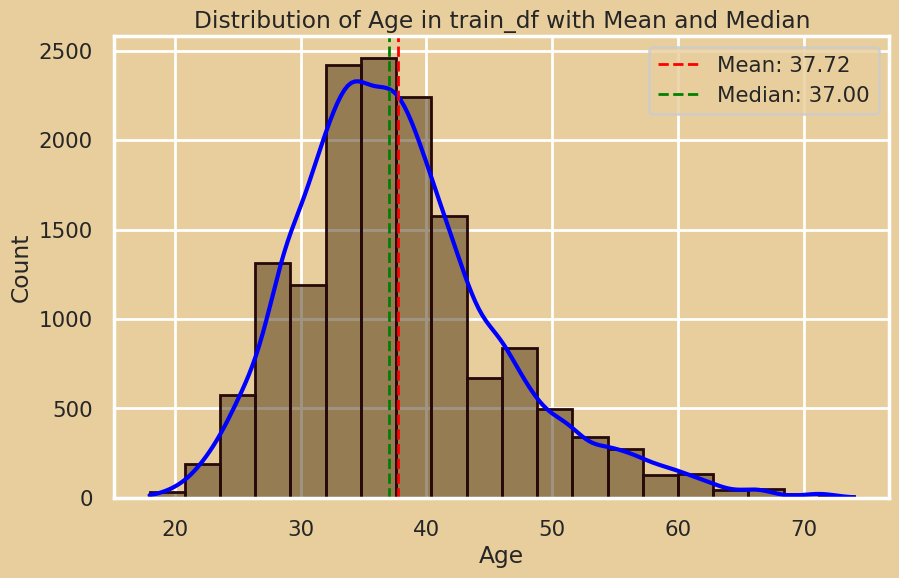

In [42]:
fig = plt.figure(figsize=(10,6))

histplot = sns.histplot(data=train_df, x="Age",
                        bins=20, color='#432C0A', edgecolor='#26090b', kde=True)

histplot.get_lines()[0].set_color('blue')

mean_value = train_df["Age"].mean()
median_value = train_df["Age"].median()

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title("Distribution of Age in train_df with Mean and Median")
plt.xlabel("Age")
plt.ylabel("Count")

plt.legend()

plt.show()

**Balance In The Dataset**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


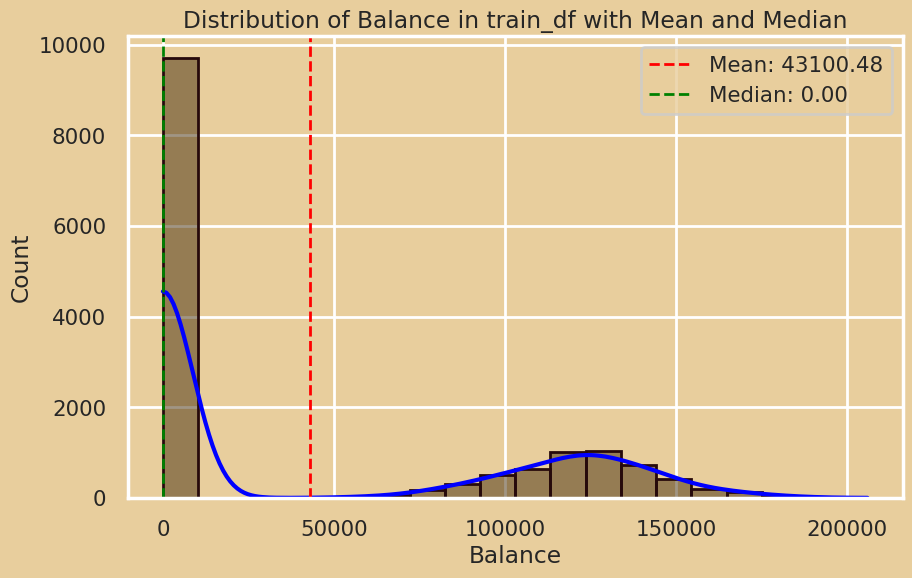

In [43]:
fig = plt.figure(figsize=(10,6))

histplot = sns.histplot(data=train_df, x="Balance",
                        bins=20, color='#432C0A', edgecolor='#26090b', kde=True)

histplot.get_lines()[0].set_color('blue')

mean_value = train_df["Balance"].mean()
median_value = train_df["Balance"].median()

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title("Distribution of Balance in train_df with Mean and Median")
plt.xlabel("Balance")
plt.ylabel("Count")

plt.legend()

plt.show()

**Estimated Salary In The Dataset**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


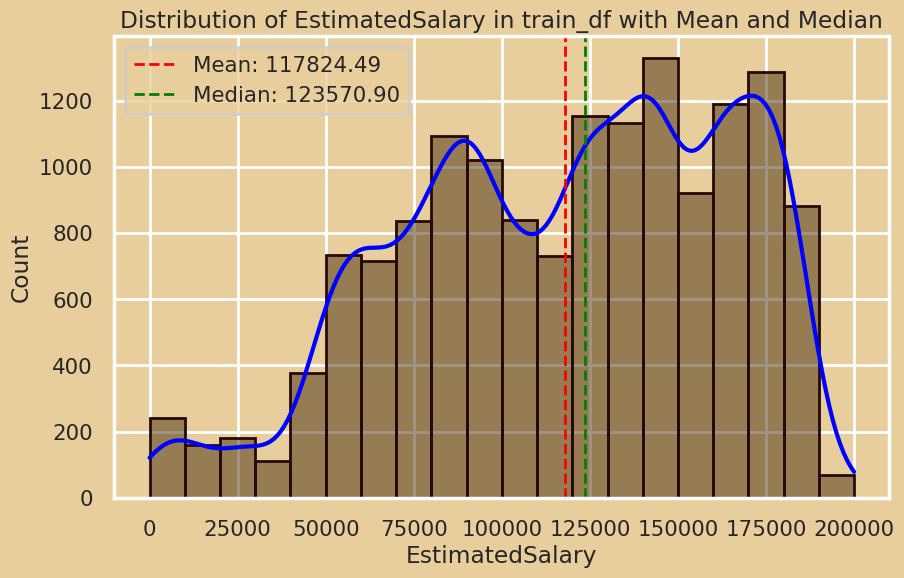

In [44]:
fig = plt.figure(figsize=(10,6))

histplot = sns.histplot(data=train_df, x="EstimatedSalary",
                        bins=20, color='#432C0A', edgecolor='#26090b', kde=True)

histplot.get_lines()[0].set_color('blue')

mean_value = train_df["EstimatedSalary"].mean()
median_value = train_df["EstimatedSalary"].median()

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

plt.title("Distribution of EstimatedSalary in train_df with Mean and Median")
plt.xlabel("EstimatedSalary")
plt.ylabel("Count")

plt.legend()

plt.show()

**Countplot by Target**

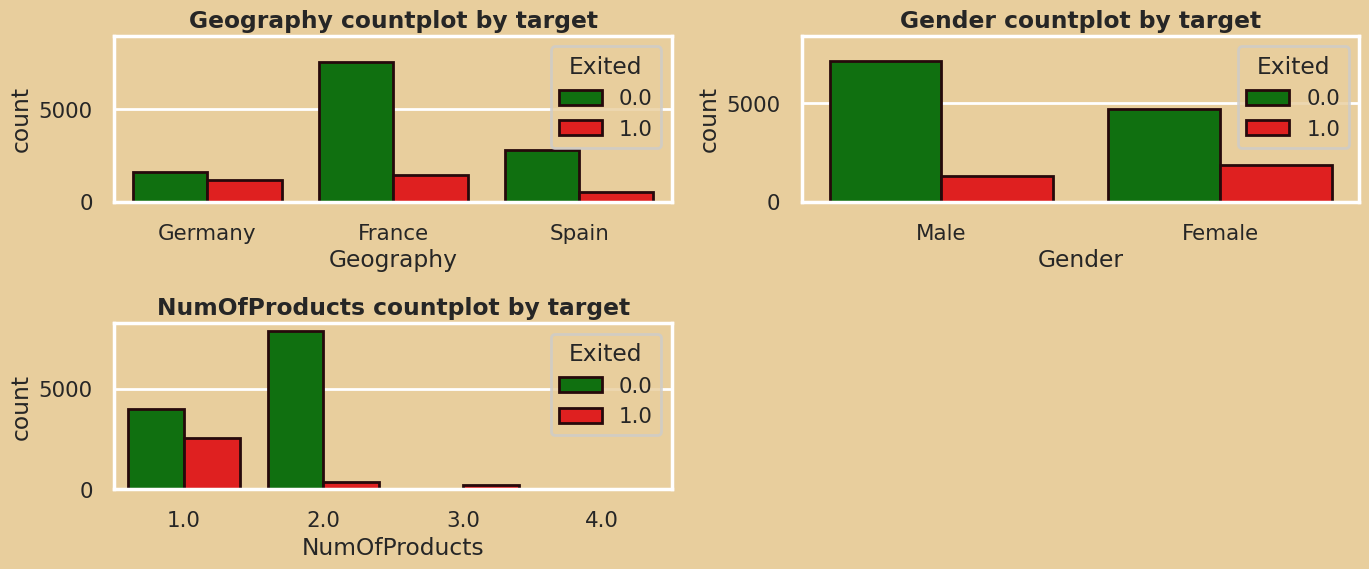

In [45]:
cat_cols = ["Geography", "Gender", "NumOfProducts"]

n_cols = 2
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3))

axes = axes.ravel()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(
        x=col,
        hue=target_col,
        data=train_df,
        ax=ax,
        palette=['green', 'red'],
        edgecolor='#26090b'
    )
    ax.set_title(f"{col} countplot by target", fontweight='bold')
    ax.set_ylim(0, train_df[col].value_counts().max() + 10)

for j in range(len(cat_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


**Handling Outliers**

In [50]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

fig = make_subplots(rows=2, cols=2)

fig.update_layout(
    plot_bgcolor="#FDDEB0",  
    paper_bgcolor="#E8CE9D",  
)

for i, col in enumerate(num_cols, start=1):
    row_num = 1 if i <= 2 else 2
    col_num = i if i <= 2 else i - 2
    fig.add_trace(
        go.Box(
            x=train_df[col],
            name=col,
            marker_color='rgba(80, 80, 80, 0.7)', 
            line_color='black'     
        ),
        row=row_num,
        col=col_num
    )

fig.update_layout(
    title_text="Boxplots of Numerical Columns",
    showlegend=False
)

fig.show()

Не думаю, что стоит удалять эти выбросы, т.к они реалистичные и могут быть важными.

**Матрица Корреляций**

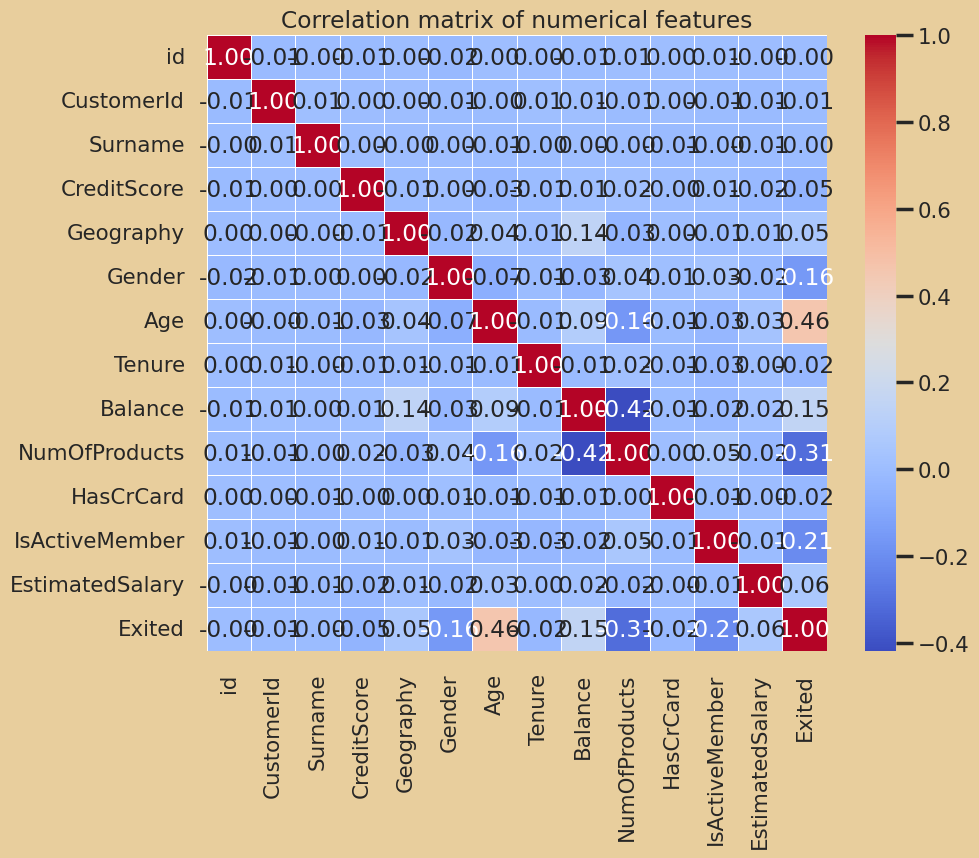

In [51]:
from sklearn.preprocessing import LabelEncoder

corr_df = train_df.copy()
catcol = [col for col in corr_df.columns if corr_df[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        corr_df[col] = le.fit_transform(corr_df[col])

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",         
    cmap="coolwarm",   
    linewidths=0.5
)
plt.title("Correlation matrix of numerical features")
plt.show()

**Распределение числовых фичей**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



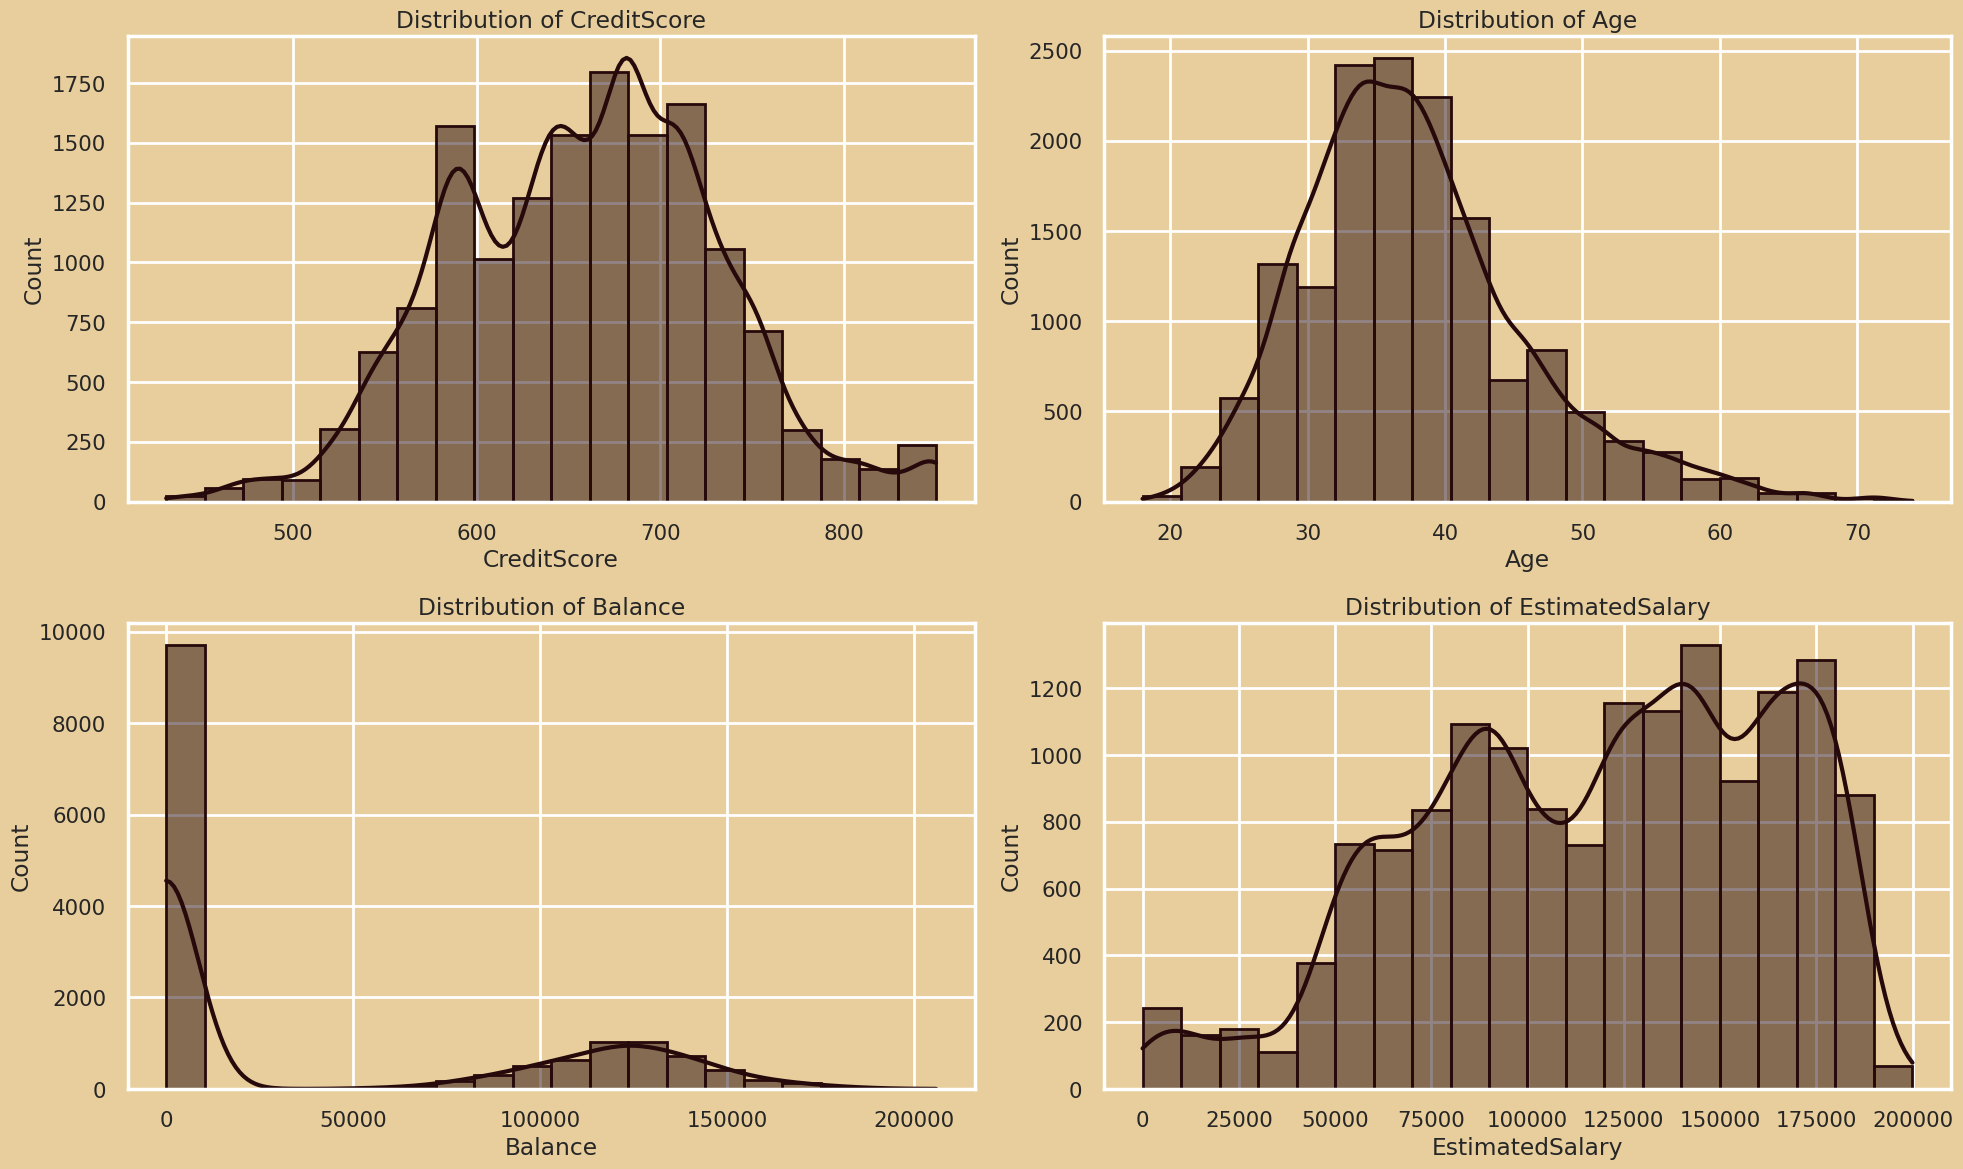

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))   
axes = axes.ravel() 

for ax, col in zip(axes, num_cols):
    sns.histplot(
        data=train_df,      
        x=col,
        bins=20,
        kde=True,
        color='#26090b',
        edgecolor='#26090b',
        ax=ax
    )
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.set_facecolor("#E8CE9D")  


fig.set_facecolor("#E8CE9D")

plt.tight_layout()
plt.show()

## 2. **Построение модели**

In [53]:
def feature_data(df):
    df = df.copy()

    df['Active_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']

    df['Age_50plus'] = (df['Age'] >= 50).astype(int)
    df['Balance_is_zero'] = (df['Balance'] == 0).astype(int)
    df['ManyProducts'] = (df['NumOfProducts'] >= 3).astype(int)

    eps = 1e-3
    df['Balance_to_Salary'] = df['Balance'] / (df['EstimatedSalary'] + eps)

    return df

In [54]:
train_df = feature_data(train_df)
test_df  = feature_data(test_df)

train_df, test_df, X, y, X_test, feat_cols, cat_cols, cat_features_idx = prepare_dataset(train_df, test_df, target_col)

In [55]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Active_by_CreditCard,Age_50plus,Balance_is_zero,ManyProducts,Balance_to_Salary
id,,,,,,,,,,,,,,,,,,
0,15653521.0,Nkemakonam,667.0,Germany,Male,33.0,3.0,131769.04,1.0,1.0,1.0,162719.69,0.0,1.0,0,0,0,0.809792
1,15699005.0,Chiekwugo,614.0,France,Female,31.0,2.0,110615.47,1.0,1.0,1.0,181879.56,0.0,1.0,0,0,0,0.608180
2,15656912.0,Chiang,683.0,Germany,Female,24.0,6.0,115074.02,2.0,1.0,0.0,109688.82,0.0,0.0,0,0,0,1.049095
3,15700772.0,Ch'ang,678.0,France,Female,38.0,9.0,0.00,1.0,1.0,0.0,122823.84,1.0,0.0,0,1,0,0.000000
4,15583850.0,Chiang,588.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,1.0,136910.18,0.0,1.0,0,1,0,0.000000


In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CreditScore           15000 non-null  float64
 1   Geography             15000 non-null  object 
 2   Gender                15000 non-null  object 
 3   Age                   15000 non-null  float64
 4   Tenure                15000 non-null  float64
 5   Balance               15000 non-null  float64
 6   NumOfProducts         15000 non-null  object 
 7   HasCrCard             15000 non-null  float64
 8   IsActiveMember        15000 non-null  float64
 9   EstimatedSalary       15000 non-null  float64
 10  Active_by_CreditCard  15000 non-null  float64
 11  Age_50plus            15000 non-null  int64  
 12  Balance_is_zero       15000 non-null  int64  
 13  ManyProducts          15000 non-null  int64  
 14  Balance_to_Salary     15000 non-null  float64
dtypes: float64(9), int64(3),

**Logistic Regression baseline**

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

num_cols = [c for c in feat_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(), cat_cols),
    ] 
)

baseline_logr = Pipeline([
    ("prep", preprocess),
    ("LR", LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced"))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X))

for train_idx, val_idx in skf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val = X.iloc[val_idx]

    baseline_logr.fit(X_train, y_train)
    oof[val_idx] = baseline_logr.predict_proba(X_val)[:, 1]

auc_logr = roc_auc_score(y, oof)
print("Baseline Roc-Auc =", auc_logr)

Baseline Roc-Auc = 0.9196266494378817


**CatBoost**

**Подбор оптимальных параметров**
(Optuna)

In [60]:
def objective(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_state": 42,
        "task_type": "CPU",
        "devices": "0",
        "verbose": False,

        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 20.0, log=True),

        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 0.5, 20.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "iterations": trial.suggest_int("iterations", 1000, 4000),

        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 64),
    }

    use_auto_class_weights = trial.suggest_categorical("use_auto_class_weights", [False, True])
    if use_auto_class_weights:
        params["auto_class_weights"] = "Balanced"

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_features_idx)
        valid_pool = Pool(X_val, y_val, cat_features=cat_features_idx)

        model = CatBoostClassifier(**params)
        model.fit(
            train_pool,
            eval_set=valid_pool,
            use_best_model=True,
            early_stopping_rounds=200,
            verbose=False,
        )

        y_pred = model.predict_proba(valid_pool)[:, 1]
        scores.append(roc_auc_score(y_val, y_pred))

    return np.mean(scores)


In [61]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Лучший AUC:", study.best_value)
print("Лучшие параметры:")
study.best_params

[I 2026-02-04 13:42:09,461] A new study created in memory with name: no-name-bb785117-70bb-4a0f-bee1-cffa02a47ad8


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-02-04 13:42:31,390] Trial 0 finished with value: 0.9271029696820277 and parameters: {'depth': 10, 'learning_rate': 0.09931570635612916, 'l2_leaf_reg': 2.9117172449093056, 'bagging_temperature': 9.135403343762956, 'random_strength': 3.166403401325072, 'border_count': 34, 'iterations': 3723, 'min_data_in_leaf': 14, 'use_auto_class_weights': False}. Best is trial 0 with value: 0.9271029696820277.
[I 2026-02-04 13:42:46,180] Trial 1 finished with value: 0.9272889493028775 and parameters: {'depth': 8, 'learning_rate': 0.06667921671257412, 'l2_leaf_reg': 1.415646783015361, 'bagging_temperature': 0.8122165141315896, 'random_strength': 8.504168833670379, 'border_count': 88, 'iterations': 2107, 'min_data_in_leaf': 38, 'use_auto_class_weights': True}. Best is trial 1 with value: 0.9272889493028775.
[I 2026-02-04 13:42:56,638] Trial 2 finished with value: 0.9300882772156404 and parameters: {'depth': 6, 'learning_rate': 0.04921097060478975, 'l2_leaf_reg': 1.6072119610619793, 'bagging_tempe

{'depth': 4,
 'learning_rate': 0.012984195787643262,
 'l2_leaf_reg': 4.117827812259832,
 'bagging_temperature': 9.204396666154175,
 'random_strength': 0.7483398912916471,
 'border_count': 196,
 'iterations': 3464,
 'min_data_in_leaf': 32,
 'use_auto_class_weights': False}

In [62]:
best_params = study.best_params.copy()

use_auto = best_params.pop("use_auto_class_weights", False)
if use_auto:
    best_params["auto_class_weights"] = "Balanced"

best_params.update({
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_state": 42,
    "task_type": "CPU",
    "devices": "0",
    "verbose": 200,
})


In [64]:
X_train = X
y_train = y
X_test  = test_df[feat_cols].copy()

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds  = np.zeros(len(X_train))
test_preds = np.zeros((len(X_test), n_splits))
fold_scores = []

for n_fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nFold {n_fold} / {n_splits}")

    X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features_idx)
    valid_pool = Pool(X_valid_fold, y_valid_fold, cat_features=cat_features_idx)

    model = CatBoostClassifier(**best_params)

    model.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True
    )

    val_pred = model.predict_proba(X_valid_fold)[:, 1]
    oof_preds[valid_idx] = val_pred

    fold_auc = roc_auc_score(y_valid_fold, val_pred)
    fold_scores.append(fold_auc)
    print(f"AUC на фолде {n_fold}: {fold_auc:.5f}")

    test_preds[:, n_fold - 1] = model.predict_proba(X_test)[:, 1]

print("\nAUC по фолдам:", [round(s, 5) for s in fold_scores])
print("Средний AUC:", np.mean(fold_scores))

oof_auc = roc_auc_score(y_train, oof_preds)
print("OOF AUC по всему train:", oof_auc)

test_pred_mean = test_preds.mean(axis=1)


Fold 1 / 5
0:	test: 0.7958630	best: 0.7958630 (0)	total: 9.21ms	remaining: 31.9s
200:	test: 0.9197334	best: 0.9197334 (200)	total: 1.38s	remaining: 22.4s
400:	test: 0.9216221	best: 0.9216302 (399)	total: 2.71s	remaining: 20.7s
600:	test: 0.9222964	best: 0.9223005 (598)	total: 4.11s	remaining: 19.6s
800:	test: 0.9228238	best: 0.9228319 (798)	total: 5.51s	remaining: 18.3s
1000:	test: 0.9231493	best: 0.9231500 (985)	total: 6.92s	remaining: 17s
1200:	test: 0.9232816	best: 0.9233377 (1179)	total: 8.33s	remaining: 15.7s
1400:	test: 0.9231736	best: 0.9233377 (1179)	total: 9.69s	remaining: 14.3s
1600:	test: 0.9232553	best: 0.9233377 (1179)	total: 11.1s	remaining: 12.9s
1800:	test: 0.9231094	best: 0.9233377 (1179)	total: 12.3s	remaining: 11.3s
2000:	test: 0.9230439	best: 0.9233377 (1179)	total: 13.7s	remaining: 10s
2200:	test: 0.9229987	best: 0.9233377 (1179)	total: 15.1s	remaining: 8.66s
2400:	test: 0.9228792	best: 0.9233377 (1179)	total: 16.6s	remaining: 7.33s
2600:	test: 0.9227306	best: 0.9

**Важность фич**

In [65]:
fi = pd.DataFrame({
    "feature": feat_cols,
    "importance": model.get_feature_importance()
}).sort_values("importance", ascending=False)

fi.head(20)


,feature,importance
6,NumOfProducts,35.221730
3,Age,26.962023
8,IsActiveMember,7.078028
1,Geography,6.195105
5,Balance,5.751009
0,CreditScore,4.477765
14,Balance_to_Salary,4.308676
2,Gender,2.863181
9,EstimatedSalary,2.745548
4,Tenure,1.454516


In [66]:
model.save_model("catboost_best_model.cbm")

In [67]:
submission = pd.DataFrame({
    "CustomerId": test_df["CustomerId"],
    "Exited": test_pred_mean
})
submission.to_csv("submission_catboost_optuna.csv", index=False)
submission.head()

,CustomerId,Exited
id,,
15000,15646539.0,0.097125
15001,15628144.0,0.072150
15002,15687953.0,0.017442
15003,15585067.0,0.322696
15004,15746190.0,0.065647


In [ ]:
submission.to_csv("submission.csv", index=False)